## This notebook reviews the Cold Lake Blend case and plots up beaching volume

In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import xarray as xr
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.dates as mpd

# graphics packages
from salishsea_tools import viz_tools
import matplotlib.pyplot as plt

# used to toggle file paths between different computers
from sys import platform

In [2]:
# User inputs.  As set up now, darwin -> paths on Rachael's "shuga" laptop 
## The other paths are for Vicky's Ocean setup

if platform == 'darwin':
    bathy_dir = '/Users/rmueller/Data/SalishSeaCast/grid/'
    results_dir = '/Users/rmueller/Projects/MIDOSS/results/HeavySinker/CLB/'
    out_dir = '/Users/rmueller/Documents/Presentations/Graphics/MIDOSS/SOILED/Beaching/'
else:
    display('Error: Need to setup directory structure')
    
# Set to [1] if you want to print to file and [0] if not
print_to_file = 1

In [3]:
results_xr = xr.open_dataset(results_dir + 'Lagrangian_CLB_crude_TP_21nov2017_28nov2017_CLB.nc')
beachingtime = results_xr.Beaching_Time[:]
thickness2D = results_xr.Thickness_2D[:]
start_time = np.datetime64('2017-11-21T00:30:00')

In [4]:
# get array size to use for converting time into numeric values
[ny,nx] = beachingtime.shape
x_range = range(nx)
y_range = range(ny)

# convert beaching time to numeric value
display('Calculating beaching time')
beachingtime_asnum = np.array([[((np.datetime64(beachingtime.values[jj,ii]) - start_time) / np.timedelta64(1, 'D')) for ii in x_range] for jj in y_range])

'Calculating beaching time'

In [5]:
beachingtime_asnum[beachingtime_asnum==0] = np.nan

'dark_background'

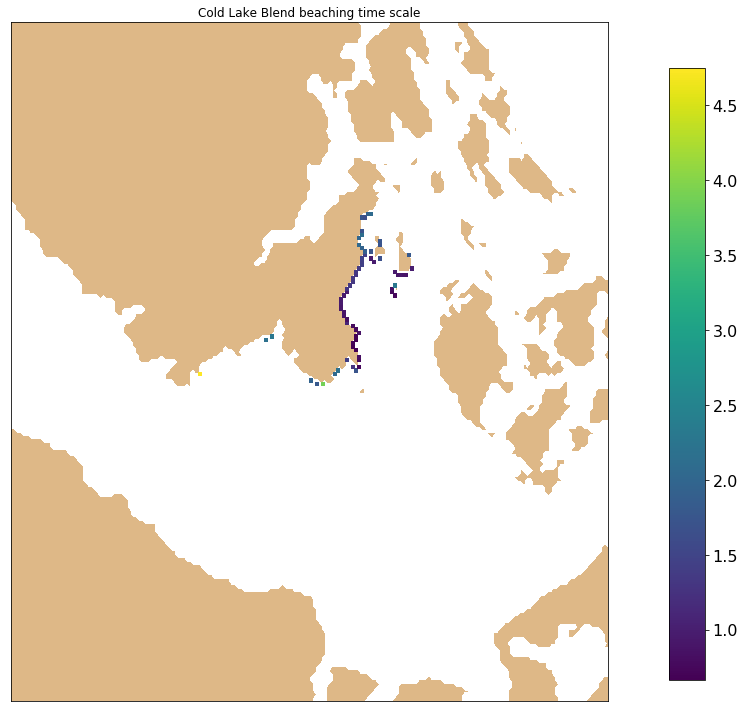

In [6]:
fig, axs = plt.subplots(1,1,figsize=(10,10))
# add land mask
viz_tools.plot_land_mask(axs,'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
# add beaching time scales
mappable = axs.pcolormesh(beachingtime_asnum)
axs.set_title("Cold Lake Blend beaching time scale")

# make pretty(ier)
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)
viz_tools.set_aspect(axs)
axs.set_xlim(100,300) #change this to set x axis limits
axs.set_ylim(200,400) #change this to set y axis limits
    
plt.tight_layout();

#[left, bottom, width, height]
ax_cbar = fig.add_axes([1.,0.05,0.05,.85])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation='vertical')
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticklabels(str([0,1,2,3,4,5,6]))
#cbar.set_label(fontsize=24)
plt.style.available[23]

## plotting beaching volume

### Using last time step of thickness 2D 

In [9]:
[nt,ny,nx] = thickness2D.shape
#beachingvolume = np.empty(thickness2D.shape)
#beachingvolume.shape

In [41]:
#beachingvolume = np.empty(thickness2D.shape)
keepers = np.isreal(beachingtime_asnum)
beachingvolume = 500 * 440 * thickness2D[nt-1,:,:].where(keepers).values * 1e-6
beachingvolume[beachingvolume==0] = np.nan
#beachingtime_asnum[beachingtime_asnum==0] = np.nan
#beachingvolume = np.asarray([
#    thickness2D[it,:,:].where(keepers) for it in range(nt)])

In [58]:
total_volume = np.sum(500 * 440 * thickness2D[nt-1,:,:].where(keepers).values) * 1e-6
display(['total volume of beached oil after spill of 1,000 m^3: ' + str(total_volume) + 'm^3'])

['total volume of beached oil after spill of 1,000 m^3: 2963.785704m^3']

'dark_background'

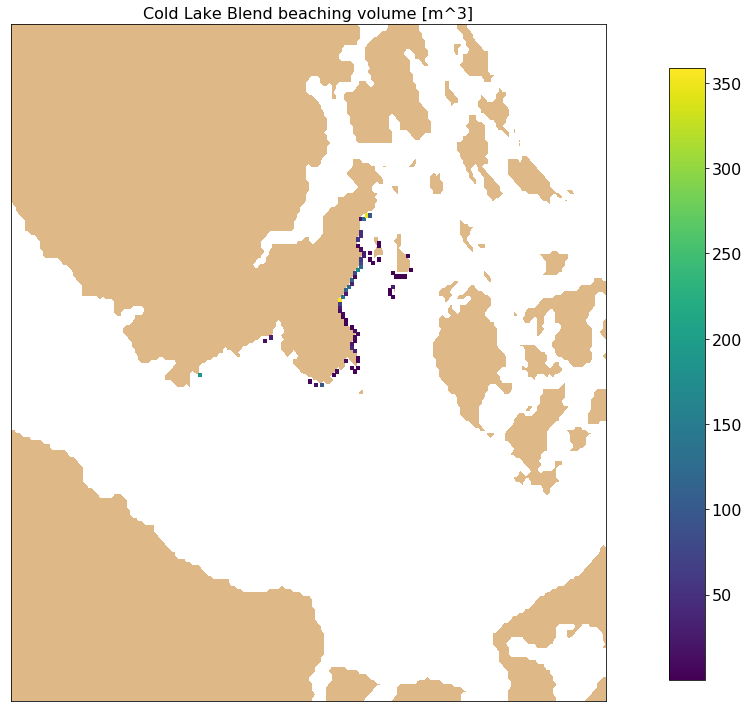

In [43]:
beachingvolume.shape
fig, axs = plt.subplots(1,1,figsize=(10,10))
# add land mask
viz_tools.plot_land_mask(axs,'/Users/rmueller/Projects/MIDOSS/MIDOSS-MOHID-grid/AfterNEMOBathy201702.nc', color = 'burlywood')
# add beaching time scales
mappable = axs.pcolormesh(beachingvolume)
axs.set_title("Cold Lake Blend beaching volume [m^3]", fontsize=16)

# make pretty(ier)
axs.get_xaxis().set_visible(False)
axs.get_yaxis().set_visible(False)
viz_tools.set_aspect(axs)
axs.set_xlim(100,300) #change this to set x axis limits
axs.set_ylim(200,400) #change this to set y axis limits
    
plt.tight_layout();

#[left, bottom, width, height]
ax_cbar = fig.add_axes([1.,0.05,0.05,.85])
cbar = plt.colorbar(mappable, cax=ax_cbar, orientation='vertical')
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticklabels(str([0,1,2,3,4,5,6]))
#cbar.set_label(fontsize=24)
plt.style.available[23]

### Using beaching volume output

In [22]:
beachingvolume = results_xr.Beaching_Volume[:] # straight up 
beachingvolume

<xarray.DataArray 'Beaching_Volume' (grid_y: 896, grid_x: 396)>
[354816 values with dtype=datetime64[ns]]
Coordinates:
  * grid_y   (grid_y) int16 0 1 2 3 4 5 6 7 ... 888 889 890 891 892 893 894 895
  * grid_x   (grid_x) int16 0 1 2 3 4 5 6 7 ... 388 389 390 391 392 393 394 395
Attributes:
    standard_name:  Beaching_Volume
    long_name:      Beaching Volume

In [24]:
beachingvolume.values

array([['2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000', ...,
        '2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000'],
       ['2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000', ...,
        '2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000'],
       ['2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000', ...,
        '2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000'],
       ..., 
       ['2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000', ...,
        '2017-11-21T00:30:00.000000000', '2017-11-21T00:30:00.000000000',
        '2017-11-21T00:30:00.000000000'],
       ['2017-11-21T00:30:00.000000000', '2

#### NOTE: Beaching volume values saved to output are datetimes, not volumes